# Modelo de agrupamiento

### Librerias

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Cargar Datos Procesados

In [227]:
data = pd.read_csv('data_processing.csv')
data.head()

,Education,Marital_Status,Income,Kids,Dias_como_cliente,Recency,Expenses,Cus_age,TotalPurchases,TotalAcceptedCamp,Complain,Response
0,Universitario,Solo,58138.0,0,663,58,1617,55,25,0,0,1
1,Universitario,Solo,46344.0,2,113,38,27,60,6,0,0,0
2,Universitario,Pareja,71613.0,0,312,26,776,48,21,0,0,0
3,Universitario,Pareja,26646.0,1,139,26,53,30,8,0,0,0
4,Posgrado,Pareja,58293.0,1,161,94,422,33,19,0,0,0


### Convertir variables categoricas a numericas

Creamos una copia del dataframe

In [228]:
df = data.copy()

Seleccionamos las caracteristicas de tipo categorica

In [229]:
var_category = df.select_dtypes(include='object').columns.to_list()
var_category

['Education', 'Marital_Status']

convertimos a valores numericos

In [230]:
x_enconded = pd.get_dummies(df, columns=var_category, drop_first=True, dtype=int)
x_enconded.head()

,Income,Kids,Dias_como_cliente,Recency,Expenses,Cus_age,TotalPurchases,TotalAcceptedCamp,Complain,Response,Education_Posgrado,Education_Universitario,Marital_Status_Solo
0,58138.0,0,663,58,1617,55,25,0,0,1,0,1,1
1,46344.0,2,113,38,27,60,6,0,0,0,0,1,1
2,71613.0,0,312,26,776,48,21,0,0,0,0,1,0
3,26646.0,1,139,26,53,30,8,0,0,0,0,1,0
4,58293.0,1,161,94,422,33,19,0,0,0,1,0,0


Verificamos que todas las variables sean numericas

In [231]:
x_enconded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198 entries, 0 to 2197
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Income                   2198 non-null   float64
 1   Kids                     2198 non-null   int64  
 2   Dias_como_cliente        2198 non-null   int64  
 3   Recency                  2198 non-null   int64  
 4   Expenses                 2198 non-null   int64  
 5   Cus_age                  2198 non-null   int64  
 6   TotalPurchases           2198 non-null   int64  
 7   TotalAcceptedCamp        2198 non-null   int64  
 8   Complain                 2198 non-null   int64  
 9   Response                 2198 non-null   int64  
 10  Education_Posgrado       2198 non-null   int64  
 11  Education_Universitario  2198 non-null   int64  
 12  Marital_Status_Solo      2198 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 223.4 KB


### Normalizar los datos

In [232]:
# instanciamos el objeto StandarScaler
scale = StandardScaler()
# normalizamos los datos
x_scaled = scale.fit_transform(x_enconded)
# mostrar registros escalados
x_scaled[:]

array([[ 0.31816423, -1.26966954,  1.52622383, ..., -0.78421233,
         0.82565964,  1.34697461],
       [-0.25285072,  1.40216737, -1.18812576, ..., -0.78421233,
         0.82565964,  1.34697461],
       [ 0.97056599, -1.26966954, -0.20602472, ..., -0.78421233,
         0.82565964, -0.74240449],
       ...,
       [ 0.26214724, -1.26966954, -0.98084815, ..., -0.78421233,
         0.82565964,  1.34697461],
       [ 0.85591758,  0.06624891, -0.97591297, ...,  1.27516485,
        -1.21115281, -0.74240449],
       [ 0.06306182,  1.40216737,  1.32388141, ...,  1.27516485,
        -1.21115281, -0.74240449]])

### Construir el Modelo

El objetivo del proyecto es realizar una segmentacion de los clientes para conocer sus preferencia y de esta forma crear nuevas campañas enfocada en estos grupos.

Vamos a utilizar el modelo KMeans con los siguientes parametros:

- Agrupar los datos en n clusteres o grupos. (n_cluster). En este caso, usamos 3.
- Utilizar el metodo de inicializacion de los centroides (init)
- Ejecutar el modelo 10 veces con diferentes inicializaciones de centroide (n_init)
- Ejecutar un maximo de 300 iteraciones en el que el algoritmo pueda converger (max_iter)


In [233]:
# crear el modelo
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)

Ahora, ajustamos el modelo a los datos escalados

In [234]:
kmeans.fit(x_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

Generamos etiquetas que asignan cada muestra a un cluster.

In [235]:
y_kmeans = kmeans.fit_predict(x_scaled)

Finalmente, calculamos la inercia que es una metrica que mide la suma de las distancias cuadradas de cada punto de datos a su centroide más cercano. 

Sirve para evaluar la calidad del clúster; un valor menor de inercia indica clústeres más compactos y bien formados. Sin embargo, la inercia por sí sola no debe ser el único criterio para seleccionar el número de clústeres.

In [236]:
inertia = kmeans.inertia_
inertia

20663.884495517843

### Hiperajuste del Modelo

Para encontrar el numero optimo de clusteres, vamos a utilizar el Metodo del Codo que es una tecnica grafica que nos indica el punto en el que agregar mas clusteres deja de mejorar significativamente la compactacion de los datos, ayudando a evitar el sobreajuste.

Vamos a correr el modelo variando el numero de clusteres y obtener el respectivo valor de inercia para cada uno

In [237]:
# lista para almacenar los valores de inercia
kmeans_inercia = []

# ejecutar el modelo 10 veces con diferente numero de clusteres
for n in np.arange(1,10):
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x_scaled)
    inercia = kmeans.inertia_
    kmeans_inercia.append(inercia)

kmeans_inercia

[28574.00000000001,
 23305.71535548169,
 20663.88449551784,
 18516.720511788797,
 17515.945320819323,
 15990.167761746294,
 14666.121738466312,
 14027.440835042817,
 13477.01525692085]

Ahora, graficamos la inercia en funcion del numero de clusteres

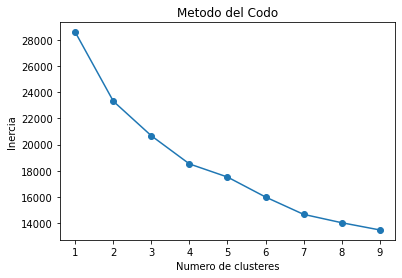

In [238]:
plt.plot(np.arange(1,10), kmeans_inercia, marker='o')
plt.title('Metodo del Codo')
plt.xlabel('Numero de clusteres')
plt.ylabel('Inercia')
plt.show()

> La grafica nos muestra que la inercia va reduciendose a partir de 3 clusteres. Sin embargo, no queda del todo claro si dicha cantidad es la optima. 

Vamos apoyarnos en otro metodo conocido como Silhouette Score para determinar el numero optimo de clusteres. 

Es una metrica que mide la calidad del agrupamiento midiendo que tan bien estan separados los clusteres y que tan bien ajustados estan los puntos de datos dentro de los clusteres.

El Score de esta metrica oscila entre 1 y -1:

- Para valores cercanos a 1 indica que los puntos estan bien separados de otros clusteres y bien agrupados dentro de sus clusteres.
- Para valores cercanos a 0 indica que los puntos estan en el borde entre clusteres en una posicin entre dos clusteres.
- Para valores cercanos a -1 indica que los puntos estan mal agrupados.

In [239]:
# importamos el metodo
from sklearn.metrics import silhouette_score

# lista para almacenar el Score de Silhouette
kmeans_sil = []

# ejecutamos el modelo 10 veces iniciando con un cluster de 2
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x_scaled)
    score = silhouette_score(x_scaled, kmeans.labels_)
    kmeans_sil.append(score)

kmeans_sil

[0.18581173739712672,
 0.17428286752635005,
 0.17979522236322285,
 0.18048728212257373,
 0.1535575409994672,
 0.16903753001205074,
 0.158551104410423,
 0.15559709953646034,
 0.15545009129367732]

Graficamos el Score en funcion del numero de clusteres para encontrar el mas optimo.

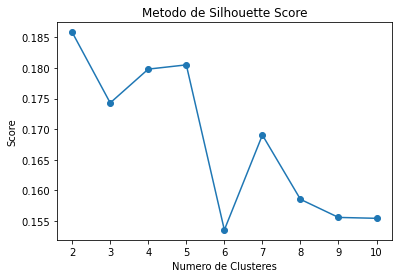

In [240]:
plt.plot(range(2,11), kmeans_sil, marker='o')
plt.title('Metodo de Silhouette Score')
plt.xlabel('Numero de Clusteres')
plt.ylabel('Score')
plt.show()

> La grafica muestra que la cantidad de clusteres optimas es 2. Sin embargo, agrupar los clientes en dos grupos no nos brinda una segmentacion relevante y por tanto, decidimos usar 3 clusteres que tambien presenta un buen Score.

### Modelo Optimo

Vamos a entrenar el modelo con 3 clusteres para obtener su valor de inercia y las etiquetas que asigna a cada cliente a un cluster 

In [241]:
kmeans_final = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans_final.fit(x_scaled)
y_label = kmeans_final.labels_
y_kmeans = kmeans_final.fit_predict(x_scaled)
inercia = kmeans_final.inertia_
print(inercia)

20663.884495517843


Creamos una copia del DataFrame y agregamos una nueva variable llamada Cluster que indica el grupo al que pertenece cada cliente.

In [242]:
df_clusters = df.copy()
df_clusters['Cluster'] = y_kmeans
df_clusters.head()

,Education,Marital_Status,Income,Kids,Dias_como_cliente,Recency,Expenses,Cus_age,TotalPurchases,TotalAcceptedCamp,Complain,Response,Cluster
0,Universitario,Solo,58138.0,0,663,58,1617,55,25,0,0,1,2
1,Universitario,Solo,46344.0,2,113,38,27,60,6,0,0,0,1
2,Universitario,Pareja,71613.0,0,312,26,776,48,21,0,0,0,2
3,Universitario,Pareja,26646.0,1,139,26,53,30,8,0,0,0,1
4,Posgrado,Pareja,58293.0,1,161,94,422,33,19,0,0,0,0


Finalmente, graficamos en un scatterplot de acuerdo al cluster al que corresponde cada cliente, las caracteristicas con una alta correlacion que son: Income (ingresos), Expenses (Gastos) y TotalPurchases (Total de compra en los diferentes medios)

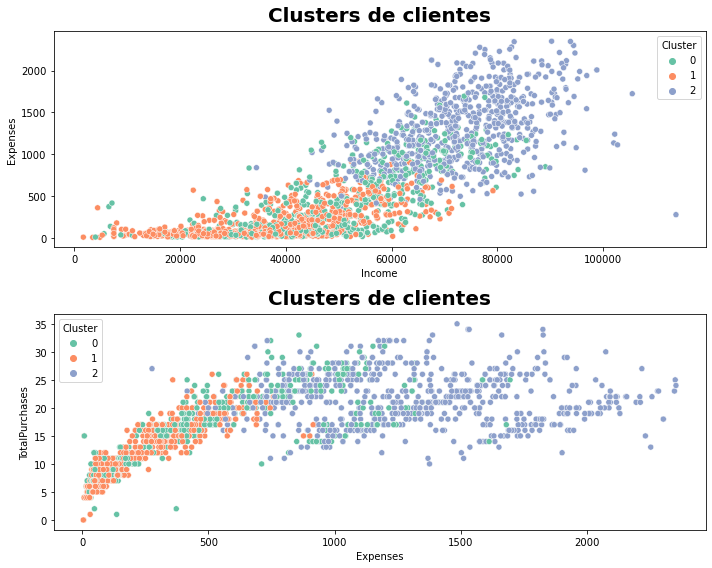

In [243]:
plt.figure(figsize=(10,8))

plt.subplot(2, 1, 1)
sns.scatterplot(data=df_clusters, x='Income', y='Expenses', hue='Cluster', palette='Set2')
plt.title('Clusters de clientes',fontsize = 20, fontweight='bold', pad=10)


plt.subplot(2, 1, 2)
sns.scatterplot(data=df_clusters, x='Expenses', y='TotalPurchases', hue='Cluster', palette='Set2')
plt.title('Clusters de clientes',fontsize = 20, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

Vamos apoyarnos en graficos de boxplot para entender la distribucion de cada cluster en las diferentes caracteristicas con valores numericos.

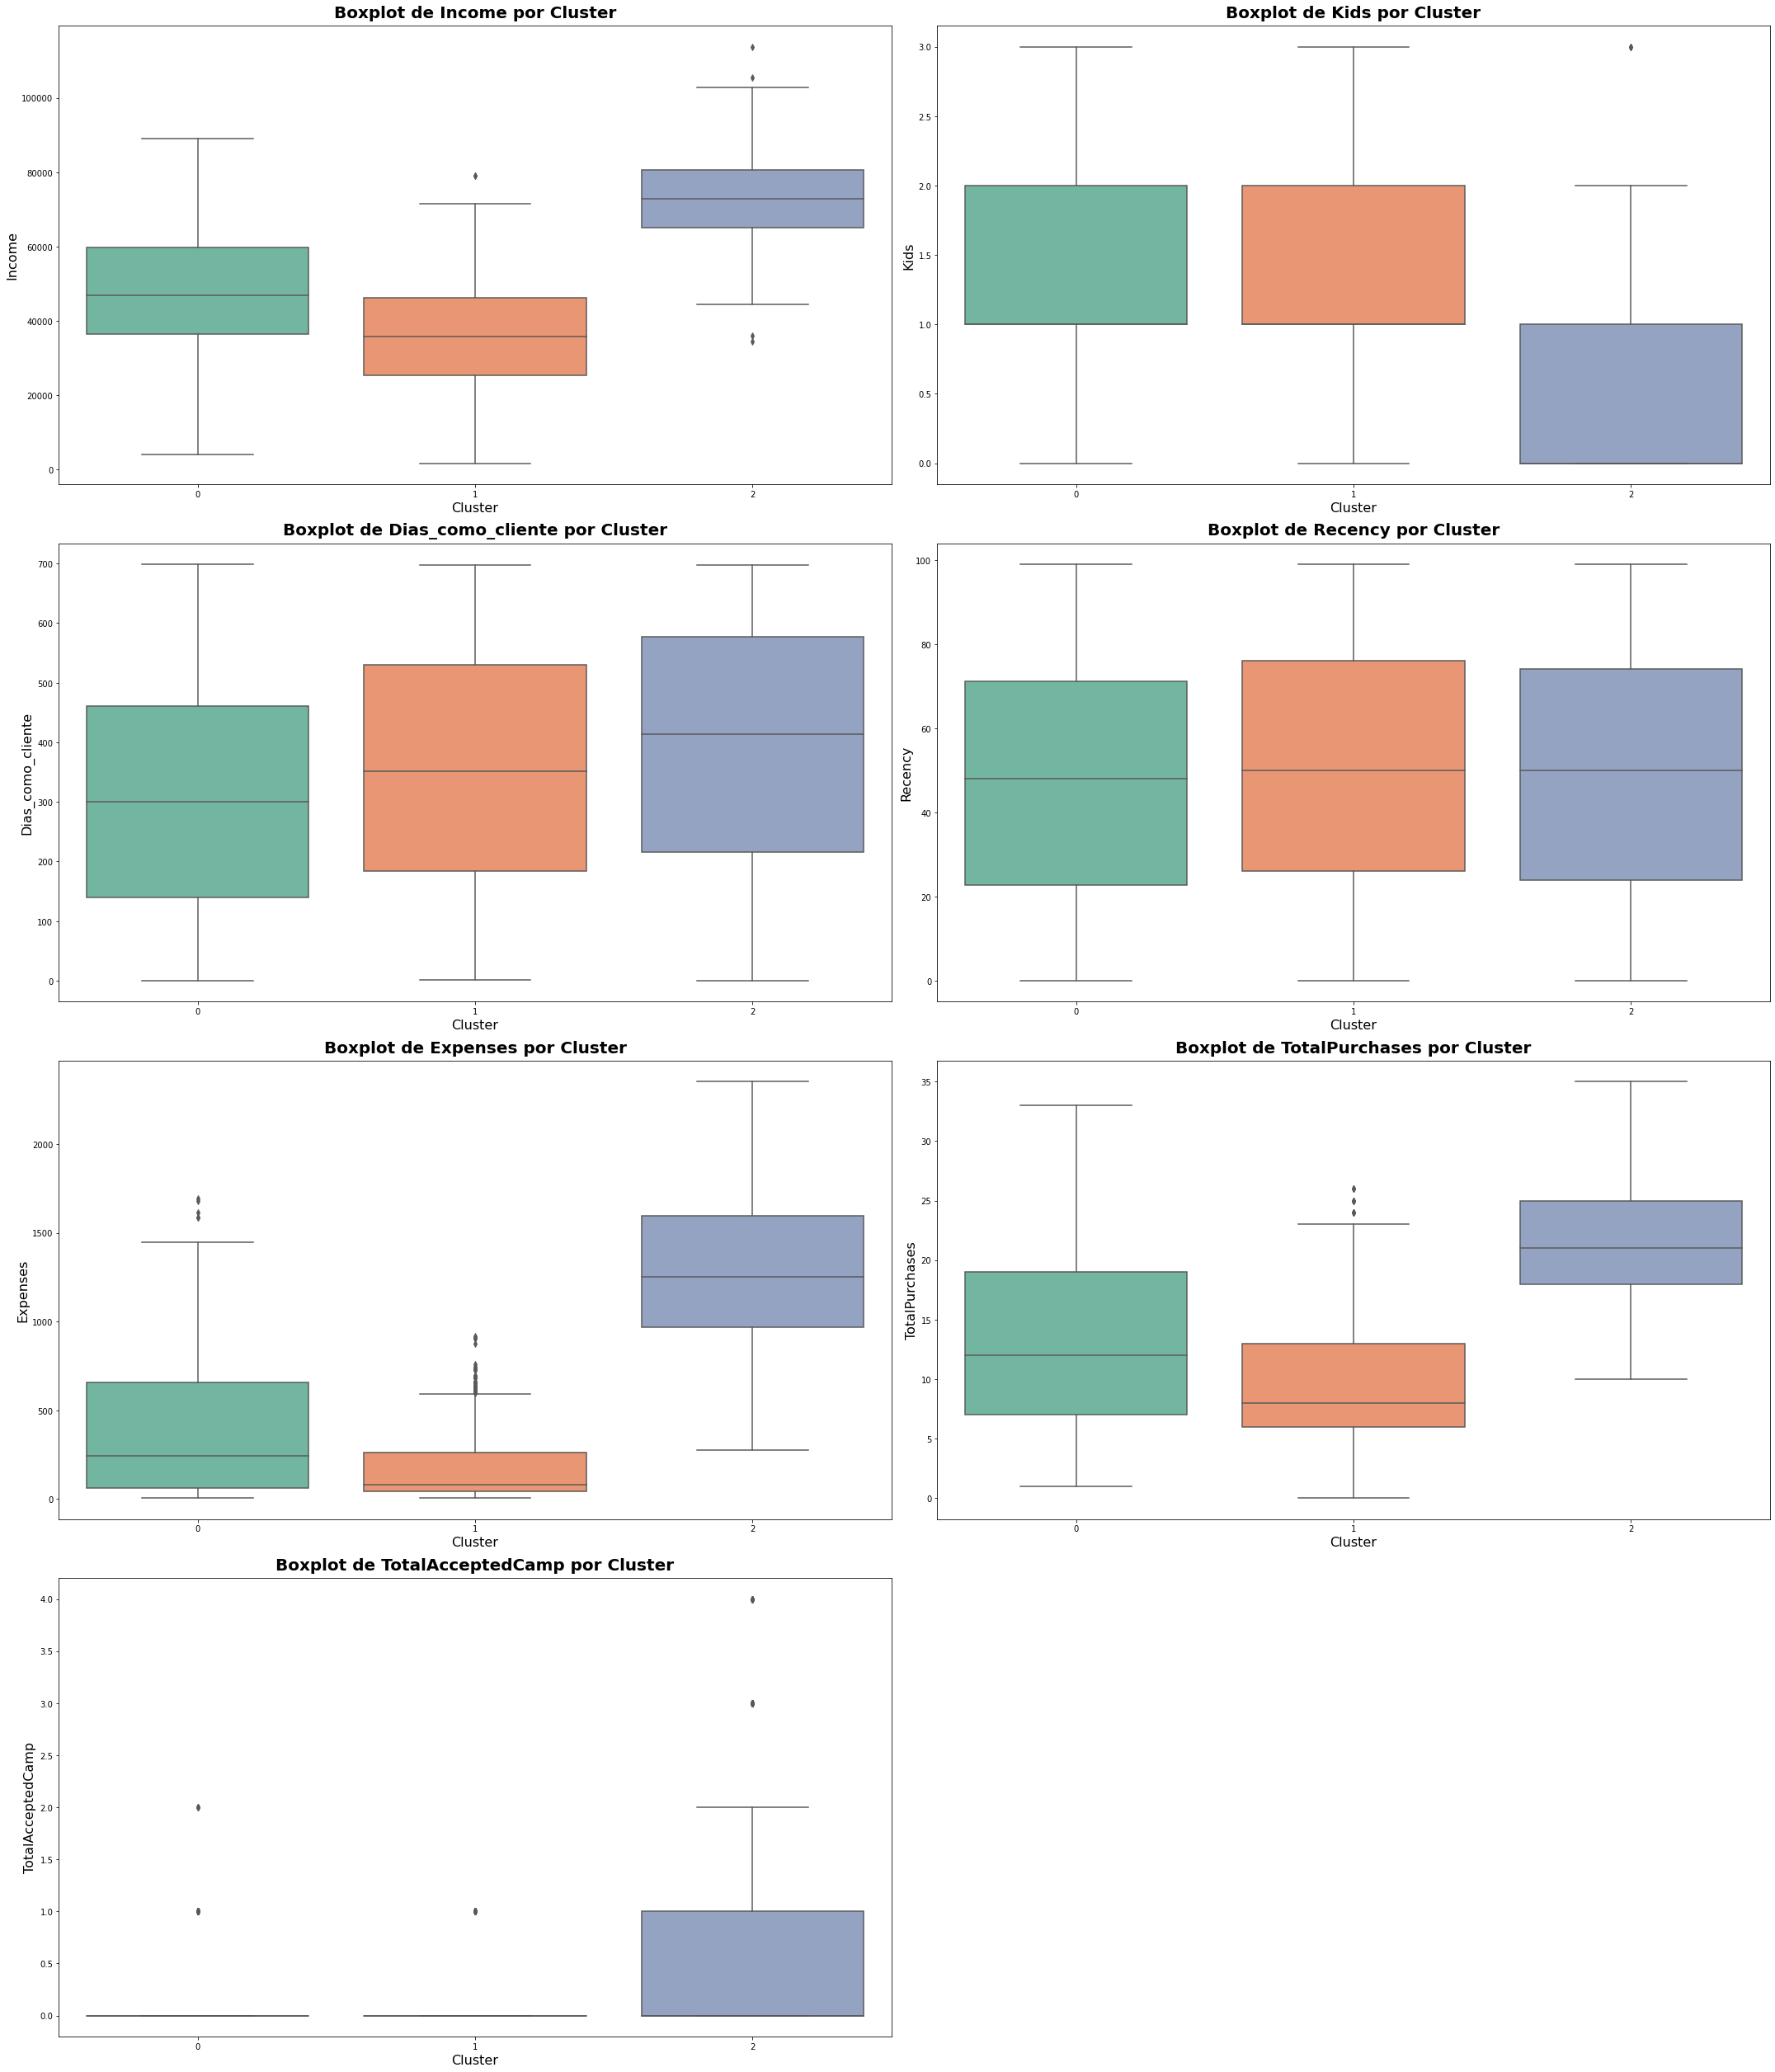

In [246]:
# lista de caracteristicas numericas a evaluar
columns_to_plot = ['Income', 'Kids', 'Dias_como_cliente', 'Recency', 'Expenses', 'TotalPurchases', 'TotalAcceptedCamp'] 

x=1
plt.figure(figsize=(30,35))
for col in columns_to_plot:
    plt.subplot(4,2,x)
    sns.boxplot(data=df_clusters, x='Cluster', y=col, palette='Set2')
    plt.title(f'Boxplot de {col} por Cluster', pad=10, fontweight='bold', fontsize=20)
    plt.xlabel('Cluster', fontsize=16)
    plt.ylabel(f"{col}" ,fontsize=16)
    plt.tight_layout()
    x+=1

Tambien vamos a crear graficos de conteo de las variables categoricas segun el cluster al que pertenecen para obtener mas informacion relevante

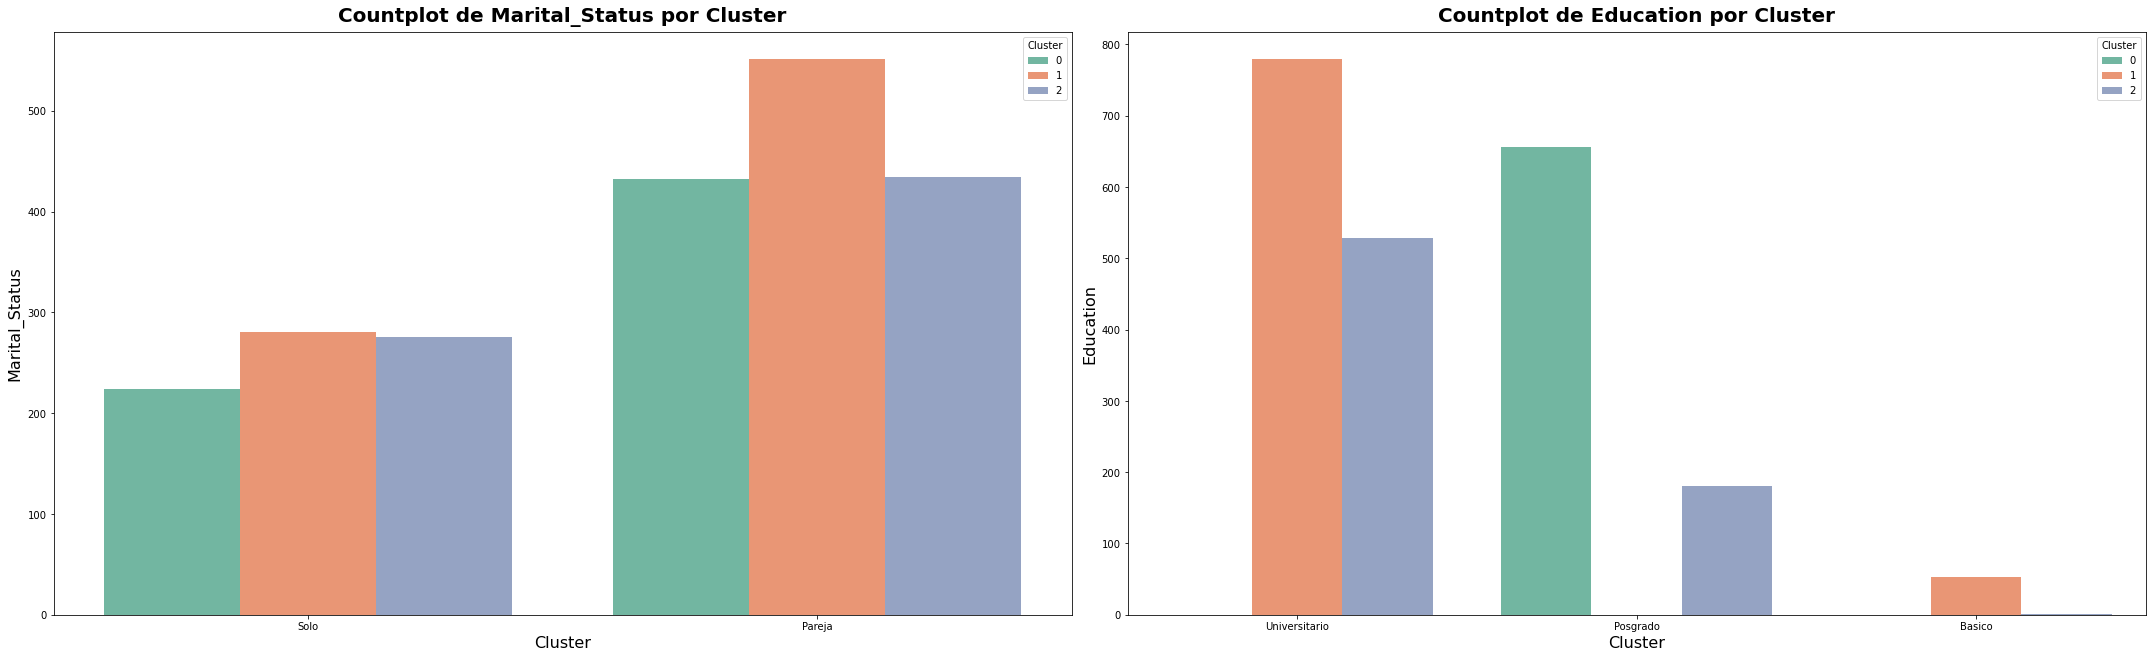

In [252]:
# lista de caracteristicas numericas a evaluar
columns_to_plot = ['Marital_Status', 'Education'] 

x=1
plt.figure(figsize=(30,35))
for col in columns_to_plot:
    plt.subplot(4,2,x)
    sns.countplot(data=df_clusters, x=col, hue='Cluster', palette='Set2')
    plt.title(f'Countplot de {col} por Cluster', pad=10, fontweight='bold', fontsize=20)
    plt.xlabel('Cluster', fontsize=16)
    plt.ylabel(f"{col}" ,fontsize=16)
    plt.tight_layout()
    x+=1

### Conclusiones

__Cluster 0__:

- Grupo de ingreso medio.
- Con 1 o 2 hijos.
- Mayormente tienen pareja.
- Con nivel educativo de posgrado.
- No acepta ofertas de campañas.
- Tiene un numero promedio de 12 compras.
- Gasta en promedio 250$ aproximadamente.

__Cluster 1__:

- Presenta el ingreso mas bajo.
- Con 1 o 2 hijos.
- Mayormente tienen pareja.
- En su mayoria tienen un nivel educativo universitario.
- No acepta ofertas de campañas.
- Presenta el numero de compra mas bajo, 7 en promedio.
- Gasta en promedio 100$ aproximadamente.

__Cluster 2__:

- Presenta el ingreso mas alto.
- Con 0 o 1 hijo.
- Mayormente tienen pareja.
- Su nivel educativo es mayormente universitario.
- Acepta ofertas de campañas ocasionalmente.
- Tiene un numero de compras promedio de 20, l mas alto de los tres grupos.
- Son los que gastan mas, con promedio de 1300$.